# Tutorial 1: Entanglement Forging for estimating the ground state energy of the H<sub>2</sub> molecule

**Entanglement forging** is a method which allows us to represent expectation values of a 2n-qubit wavefunction as sums of multiple expectation values of n-qubit states, embedded in a classical optimization, thus doubling the size of the system that can be exactly simulated with a fixed number of qubits.

In the `Circuit Knitting Toolbox`, entanglement forging is implemented to estimate the ground state energy of a molecule. Entanglement forging is most easily run using the `EntanglementForgingGroundStateSolver` interface, which wraps most of the algorithm within a single function call, `solve`. Steps 1-4 describe the workflow within `solve`. See the [explanatory material](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/docs/explanation/entanglement_forging/index.rst) for more detailed information:

1. **Decompose**:
    * Decompose the 2n-qubit ansatz (wavefunction) into many parameterized, n-qubit ansatze
    * Decompose the 2n-qubit observable (Hamiltonian) into many n-qubit observables


2. **Evaluate**:
    * Use the n-qubit expectation values to reconstruct an estimation of the original 2n-qubit expectation value
  
  
3. **Reconstruct** 
    * Use the expectation values to reconstruct an estimation of the expectation value for the 2n-qubit system
  
  
4. **If the expectation value (energy) has not converged, update the ansatze parameters and continue with Step 2**

### Instantiate the `ElectronicStructureProblem`

First, we set up the $\mathrm{H}_2$ molecule, specify the driver and converter, and instantiate an  `ElectronicStructureProblem`, just like is done in the [Qiskit Nature VQE tutorial](https://github.com/Qiskit/qiskit-nature/blob/stable/0.4/docs/tutorials/03_ground_state_solvers.ipynb).

In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicStructureProblem

driver = PySCFDriver("H 0.0 0.0 0.0; H 0.0 0.0 0.735")
driver.run()
problem = driver.to_problem()

### Configure the entanglement forging specific inputs

The ansatz for Entanglement Forging consists of a set of input bitstrings and a parameterized circuit.  (See the [explanatory material](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/docs/explanation/entanglement_forging/index.rst) section of the documentation for additional background on the method.) For this demo, we will use the same bitstrings and ansatz for both the U and V subsystems, and we will use the [TwoLocal](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) circuit from Qiskit.

In [2]:
from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz
from qiskit.circuit.library import TwoLocal

ansatz = EntanglementForgingAnsatz(
    circuit_u=TwoLocal(2, [], "cry", [[0, 1], [1, 0]], reps=1),
    bitstrings_u=[(1, 0), (0, 1)],
)

ansatz.circuit_u.draw()

┌──────────────────────┐
q_0: ┤0                     ├
     │  TwoLocal(θ[0],θ[1]) │
q_1: ┤1                     ├
     └──────────────────────┘

### Set up the Qiskit Runtime Service

The Qiskit Runtime Service provides access to Qiskit Runtime Primitives and quantum backends. See the [Qiskit Runtime documentation](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) for more information.  Here, we specify the backend(s) to be used to evaluate the circuits. Backends could be [simulator(s) and/or quantum device(s)](https://quantum-computing.ibm.com/services/resources?tab=systems).

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# By default, use a local simulator to implement the Qiskit Runtime Primitives
service = None

# Uncomment the following line to instead use the Qiskit Runtime Service.
# service = QiskitRuntimeService(channel="ibm_quantum")

backend_names = ["ibmq_qasm_simulator"] * 2

# If a single set of options are passed, it will be applied to all backends
options = [Options(execution={"shots": 1000}), Options(execution={"shots": 2000})]

### Set up `EntanglementForgingGroundStateSolver`
Next, we set up the `EntanglementForgingGroundStateSolver`. It is passed the ansatz, a classical optimizer ([COBYLA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html?highlight=cobyla#qiskit.algorithms.optimizers.COBYLA), in this case), and an initial point.

 * The `ansatz` field is required.
 * If no optimizer is passed, [SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html) with default settings will be used.
 * If a Qiskit Runtime Service is not passed, then a local simulator will be used with the [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html), and the `backend_names` argument will be ignored.
 * If multiple backend names are passed, the expectation value calculations at each iteration will be divided evenly among them and calculated in parallel.
 * If a single options argument is passed, it will be used for all backends. If a list of options is passed, they will be synchronized with the backends 1:1
 * If the `initial_point` field is not set, it will be initialized to all 0's.

In [4]:
import numpy as np
from qiskit.algorithms.optimizers import COBYLA
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)

optimizer = COBYLA(maxiter=100)

solver = EntanglementForgingGroundStateSolver(
    ansatz=ansatz,
    optimizer=optimizer,
    service=service,
    backend_names=backend_names,
    options=options,
    initial_point=[0.0, np.pi / 2],
)

### Calculate the ground state energy

Once a user has set up their `ElectronicStructureProblem`, `EntanglementForgingAnsatz`, and other program options, the only thing remaining is call `EntanglementForgingGroundStateSolver.solve`.

In [5]:
%%capture

results = solver.solve(problem)

### Visualize the results

Visualize the convergence of the estimated ground state energy and the Schmidt coefficients as the ansatz parameters are optimized.

Energy:


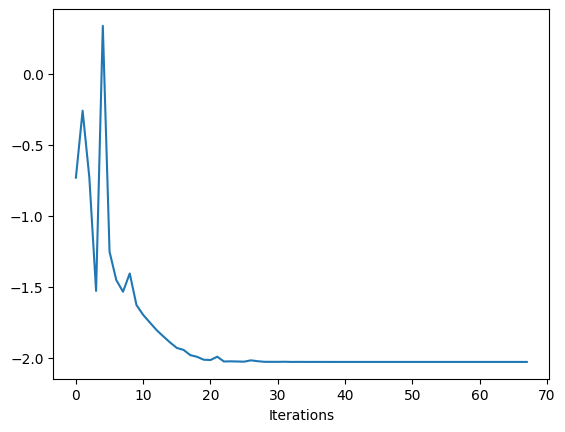

Schmidt Coefficients:


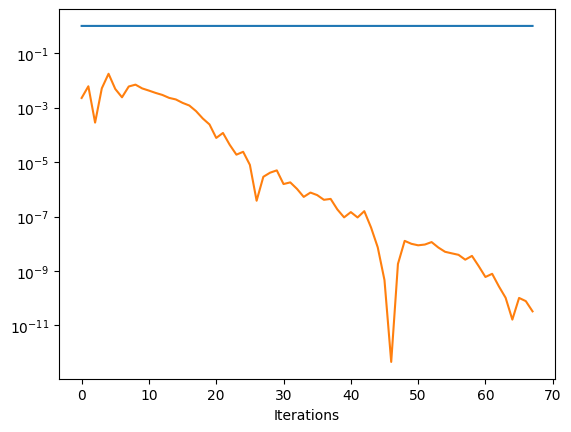

Parameters:


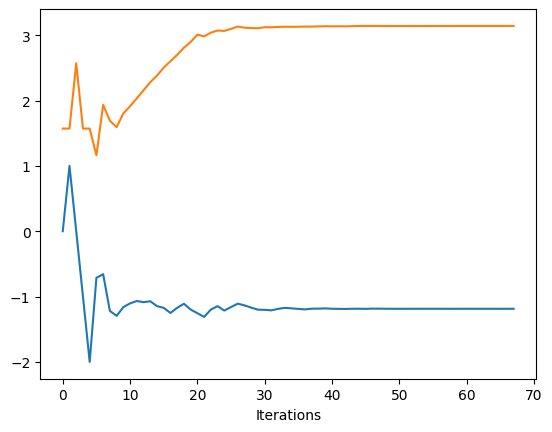

In [6]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [7]:
import qiskit.tools.jupyter

%qiskit_version_table

### This code is a Qiskit project.

© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.